Compose(
    ToTensor()
)
torch.Size([1, 28, 28])


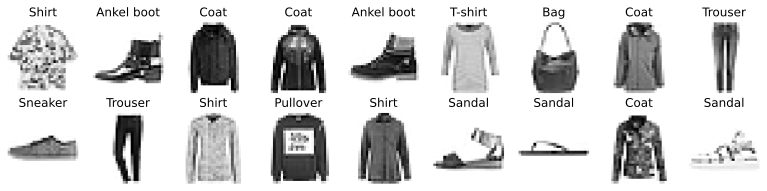

In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils import data
from torchvision import transforms
from tqdm import tqdm
from torch.nn import functional as F
from matplotlib_inline import backend_inline
from IPython import display

def use_svg_display():
    """使用svg格式在Jupyter中显示绘图

    Defined in :numref:`sec_calculus`"""
    backend_inline.set_matplotlib_formats('svg')

use_svg_display()

myseed = 1314  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

trans = [transforms.ToTensor()]
# trans.insert(0,transforms.Resize(96))
trans = transforms.Compose(trans)
print(trans)
train_data = torchvision.datasets.FashionMNIST(
    root="./MNIST", train=True, transform=trans, download=True)
test_data  = torchvision.datasets.FashionMNIST(
    root="./MNIST", train=False, transform=trans, download=True)
device  = torch.device('cuda' if torch.cuda.is_available else 'cpu')

BATCH_SIZE = 256  

train_dataloader = data.DataLoader(dataset = train_data,batch_size = BATCH_SIZE,shuffle = True)
test_dataloader  = data.DataLoader(dataset = test_data,batch_size = 50)

class_str = ["T-shirt","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankel boot"]

def get_class(indices):
    return class_str[int(indices)]

def show_img(img,label,nrow,ncol,scale=1.5):
    fig,axes = plt.subplots(nrow,ncol, figsize=(ncol*scale,nrow*scale)) 
    axes = axes.flatten()
    for i,(img,ax) in enumerate(zip(img,axes)):
        ax.imshow(img.squeeze(),cmap="Greys")
        ax.set_title(get_class(label[i]))
        ax.axis('off')
    plt.show()

x, y = next(iter(train_dataloader))
print(x[0].shape)
show_img(x,y,2,9)

def accuracy(y_pred,y):
    y_pred = y_pred.softmax(1).argmax(1)
    total = y.shape[0]
    right = (y_pred == y).sum()
    print("Acc:%.2f%%"%(right/total*100))
    return (right,total)

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_softmax_scratch`"""
        # 增量地绘制多条线
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

def train(train_loader,test_loader,model,n_epoch,lr,device):
    model.to(device)
    optim = torch.optim.SGD(model.parameters(),lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(n_epoch):
        bar = tqdm(train_loader,total=len(train_loader),unit_scale=BATCH_SIZE)
        for x,y in bar:
            optim.zero_grad()
            x,y = x.to(device),y.to(device)
            pred = model(x)
            loss = criterion(pred,y)
            loss.backward()
            optim.step()
            bar.set_description(f'Epoch:[{epoch+1:02d}/{n_epoch}]')
            bar.set_postfix(loss=float(loss))
        with torch.no_grad():
            for x,y in test_loader:
                x,y = x.to(device),y.to(device)
                pred = model(x)
                accuracy(pred,y)
                break


In [2]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean.data, moving_var.data

class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

In [3]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm()
  (2): Sigmoid()
  (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm()
  (6): Sigmoid()
  (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=256, out_features=120, bias=True)
  (10): BatchNorm()
  (11): Sigmoid()
  (12): Linear(in_features=120, out_features=84, bias=True)
  (13): BatchNorm()
  (14): Sigmoid()
  (15): Linear(in_features=84, out_features=10, bias=True)
)

In [4]:
train(train_dataloader,test_dataloader,net,10,1,device)

Epoch:[01/10]: 100%|██████████| 60160/60160 [00:05<00:00, 10844.70it/s, loss=0.544]


Acc:54.00%


Epoch:[02/10]: 100%|██████████| 60160/60160 [00:03<00:00, 16117.35it/s, loss=0.485]


Acc:64.00%


Epoch:[03/10]: 100%|██████████| 60160/60160 [00:03<00:00, 15281.51it/s, loss=0.345]


Acc:64.00%


Epoch:[04/10]: 100%|██████████| 60160/60160 [00:04<00:00, 14823.02it/s, loss=0.396]


Acc:50.00%


Epoch:[05/10]: 100%|██████████| 60160/60160 [00:04<00:00, 14512.25it/s, loss=0.408]


Acc:62.00%


Epoch:[06/10]: 100%|██████████| 60160/60160 [00:04<00:00, 14726.25it/s, loss=0.328]


Acc:82.00%


Epoch:[07/10]: 100%|██████████| 60160/60160 [00:04<00:00, 14518.73it/s, loss=0.293]


Acc:74.00%


Epoch:[08/10]: 100%|██████████| 60160/60160 [00:04<00:00, 14337.16it/s, loss=0.218]


Acc:78.00%


Epoch:[09/10]: 100%|██████████| 60160/60160 [00:04<00:00, 14470.39it/s, loss=0.243]


Acc:78.00%


Epoch:[10/10]: 100%|██████████| 60160/60160 [00:04<00:00, 14438.76it/s, loss=0.273]

Acc:72.00%


In [5]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

In [6]:
train(train_dataloader,test_dataloader,net,10,1,device)

Epoch:[01/10]: 100%|██████████| 60160/60160 [00:04<00:00, 14077.46it/s, loss=0.608]


Acc:74.00%


Epoch:[02/10]: 100%|██████████| 60160/60160 [00:03<00:00, 15234.87it/s, loss=0.431]


Acc:74.00%


Epoch:[03/10]: 100%|██████████| 60160/60160 [00:03<00:00, 15247.48it/s, loss=0.345]


Acc:78.00%


Epoch:[04/10]: 100%|██████████| 60160/60160 [00:03<00:00, 15171.26it/s, loss=0.383]


Acc:82.00%


Epoch:[05/10]: 100%|██████████| 60160/60160 [00:03<00:00, 15352.27it/s, loss=0.344]


Acc:88.00%


Epoch:[06/10]: 100%|██████████| 60160/60160 [00:03<00:00, 15265.08it/s, loss=0.39] 


Acc:86.00%


Epoch:[07/10]: 100%|██████████| 60160/60160 [00:03<00:00, 15115.42it/s, loss=0.231]


Acc:82.00%


Epoch:[08/10]: 100%|██████████| 60160/60160 [00:03<00:00, 15234.59it/s, loss=0.311]


Acc:78.00%


Epoch:[09/10]: 100%|██████████| 60160/60160 [00:04<00:00, 15016.21it/s, loss=0.196]


Acc:84.00%


Epoch:[10/10]: 100%|██████████| 60160/60160 [00:03<00:00, 15120.06it/s, loss=0.268]


Acc:84.00%
